In [69]:
import torch

print("GPU 사용 가능 여부:", torch.cuda.is_available())
print("GPU 개수:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU 이름:", torch.cuda.get_device_name(0))
    print("CUDA 버전:", torch.version.cuda)

GPU 사용 가능 여부: True
GPU 개수: 1
GPU 이름: NVIDIA GeForce RTX 4070 Laptop GPU
CUDA 버전: 11.8


In [74]:
!nvidia-smi

Thu Feb 27 21:27:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.03                 Driver Version: 561.03         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P0             14W /   75W |       0MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [73]:
import GPUtil

gpus = GPUtil.getGPUs()
for gpu in gpus:
    print(f"GPU 이름: {gpu.name}")
    print(f"총 메모리: {gpu.memoryTotal:.2f} MB")
    print(f"사용 중 메모리: {gpu.memoryUsed:.2f} MB")
    print(f"사용 가능 메모리: {gpu.memoryFree:.2f} MB")

GPU 이름: NVIDIA GeForce RTX 4070 Laptop GPU
총 메모리: 8188.00 MB
사용 중 메모리: 0.00 MB
사용 가능 메모리: 7948.00 MB


벡터 스토어: https://colab.research.google.com/drive/12nrSZdoVSiqID-LaCGjKVjM8gNqFLERt?usp=sharing

In [1]:
!pip install langchain langchain-openai tiktoken openai faiss-cpu pypdf chromadb langchain_community

     ---------------------------------------- 0.0/67.3 kB ? eta -:--:--
     ---------------------------------------- 67.3/67.3 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/55.3 kB ? eta -:--:--
   ---------------------------------------- 55.3/55.3 kB 2.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/893.9 kB ? eta -:--:--
   ---------------------------------- ---- 788.5/893.9 kB 16.6 MB/s eta 0:00:01
   --------------------------------------- 893.9/893.9 kB 14.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/13.7 MB ? eta -:--:--
   - -------------------------------------- 0.6/13.7 MB 12.2 MB/s eta

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.32.0 requires protobuf<5,>=3.20, but you have protobuf 5.29.3 which is incompatible.
streamlit 1.32.0 requires tenacity<9,>=8.1.0, but you have tenacity 9.0.0 which is incompatible.
tensorflow-intel 2.16.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.29.3 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
os.environ['OPENAI_API_KEY'] =  ""

> **데이터 살펴보기**

* 데이터는 한국은행에서 제공하는 '2020_경제금융용어 700선_게시.pdf'를 사용한다.

In [3]:
import os
import re
import getpass
import matplotlib.pyplot as plt
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain.chains import RetrievalQA
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

https://www.bok.or.kr/portal/bbs/B0000249/view.do?nttId=235017&menuNo=200765  

위 링크에서 pdf 파일을 다운로드 받아서 업로드합니다.  

2020_경제금융용어 700선_게시.pdf

해당 파일을 열어서 확인하면 다음과 같습니다.

![](https://wikidocs.net/images/page/215361/%EC%BA%A1%EC%B2%98%EC%9D%B4%EB%AF%B8%EC%A7%80.PNG)

PDF를 로드하여 여러 개의 문서로 분할해주는  

```from langchain.document_loaders import PyPDFLoader```를 사용합니다.

In [ ]:
# 다운로드 코드
!wget -O "2020_경제금융용어 700선_게시.pdf" "https://raw.githubusercontent.com/chatgpt-kr/openai-api-tutorial/main/ch07/2020_%EA%B2%BD%EC%A0%9C%EA%B8%88%EC%9C%B5%EC%9A%A9%EC%96%B4%20700%EC%84%A0_%EA%B2%8C%EC%8B%9C.pdf"

--2025-02-27 10:27:54--  https://raw.githubusercontent.com/chatgpt-kr/openai-api-tutorial/main/ch07/2020_%EA%B2%BD%EC%A0%9C%EA%B8%88%EC%9C%B5%EC%9A%A9%EC%96%B4%20700%EC%84%A0_%EA%B2%8C%EC%8B%9C.pdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5946083 (5.7M) [application/octet-stream]
Saving to: ‘2020_경제금융용어 700선_게시.pdf’

2020_경제금융용어 7 100%[===================>]   5.67M  --.-KB/s    in 0.09s   

2025-02-27 10:27:54 (63.4 MB/s) - ‘2020_경제금융용어 700선_게시.pdf’ saved [5946083/5946083]



## **Data Spec Check**

사용할 데이터를 점검하는 단계입니다.

In [24]:
from langchain.document_loaders import PyPDFLoader

loader = PyPDFLoader("2020_경제금융용어 700선_게시.pdf")
texts = loader.load_and_split()

* load_and_split()과 관련된 공식 문서:

https://api.python.langchain.com/en/latest/document_loaders/langchain.document_loaders.pdf.PyPDFLoader.html  

In [25]:
print('문서의 수 :', len(texts))

문서의 수 : 366


#### PDF 문서가 총 366개의 텍스트로 분할되었습니다. 그 중 임의로 15번 문서를 출력해보겠습니다.

Document(metadata={'source': '파일명', 'page': 기존 파일에서 몇 페이지였는지}, page_content=실제 내용)

In [7]:
texts[15]

Document(metadata={'producer': 'Smart PDF Imposition 1.0', 'creator': 'Smart PDF Imposition 1.0', 'creationdate': 'January 31, 2018 16:21', 'author': 'INSUNG DATA INC.', 'creationdate--text': 'January 31, 2018 16:21', 'moddate': 'January 31, 2018 16:21', 'moddate--text': 'January 31, 2018 16:21', 'subject': 'CoreImposition PDF 1.0 Output', 'title': '°æÁ¦±ÝÀ¶¿ë¾î 700¼±-ÃÖÁ¾.PDF', 'source': '2020_경제금융용어 700선_게시.pdf', 'total_pages': 371, 'page': 19, 'page_label': '20'}, page_content='3\nㄱ \n신용을 모두 포괄하는 것으로 크게 가계대출과 판매신용으로 구분된다. 현재 가계신용통\n계는 2002년 말 잔액부터 분기별로 제공되고 있다. 가계신용통계는 우리나라 가계부문의 \n부채 규모 및 변동 등을 파악하는 데 널리 활용되고 있다 .\n가계처분가능소득 \n가계처분가능소득(PDI; Personal Disposable Income)은 가계가 맘대로 소비와 저축\n으로 처분할 수 있는 소득을 의미한다. 흔히 국민들의 생활수준을 파악해 볼 수 있는 \n지표로 1인당 GNI가 널리 쓰이고 있으나 국민총소득에는 가계 뿐 아니라 기업 금융기관 \n정부가 벌어 들인 소득이 모두 포함되어 있다. 따라서 기업과 금융기관 등이 가계부문 \n보다 더 많은 소득을 벌어 1인당 국민총소득(GNI)이 높아진 경우에는 가계가 느끼는 \n체감경기는 전체 경기와 괴리가 있게 된다. 1인당 가계총처분가능소득(PGDI; Personal \nGross Disposable Income)은 가계부문의 총처분가능소득을 연앙인구로 나누

형식은 page_content에는 분할된 텍스트의 본문이 저장되어져 있고, source에는 해당 본문의 원본 파일의 이름이 저장되어져 있습니다.

In [8]:
# 문서를 직접 접근하기 위해서는 .page_content를 사용.
texts[15].page_content

'3\nㄱ \n신용을 모두 포괄하는 것으로 크게 가계대출과 판매신용으로 구분된다. 현재 가계신용통\n계는 2002년 말 잔액부터 분기별로 제공되고 있다. 가계신용통계는 우리나라 가계부문의 \n부채 규모 및 변동 등을 파악하는 데 널리 활용되고 있다 .\n가계처분가능소득 \n가계처분가능소득(PDI; Personal Disposable Income)은 가계가 맘대로 소비와 저축\n으로 처분할 수 있는 소득을 의미한다. 흔히 국민들의 생활수준을 파악해 볼 수 있는 \n지표로 1인당 GNI가 널리 쓰이고 있으나 국민총소득에는 가계 뿐 아니라 기업 금융기관 \n정부가 벌어 들인 소득이 모두 포함되어 있다. 따라서 기업과 금융기관 등이 가계부문 \n보다 더 많은 소득을 벌어 1인당 국민총소득(GNI)이 높아진 경우에는 가계가 느끼는 \n체감경기는 전체 경기와 괴리가 있게 된다. 1인당 가계총처분가능소득(PGDI; Personal \nGross Disposable Income)은 가계부문의 총처분가능소득을 연앙인구로 나누어 계산한 \n지표로 가계의 구매력을 가장 정확히 가늠해 볼 수 있는 소득지표이다 . \n 연관검색어 : 국민총소득 (GNI)\n가교은행\n청산 대상 금융기관의 자산, 부채를 임시로 넘겨받아 예금, 출금 등의 업무를 대행하고 \n합병, 채권채무관계 조정 등 후속조치를 수행하는 은행을 말한다. 금융기관이 파산한 경우 \n예금보험제도는 청산, 매각, 자산부채승계, 가교은행을 통한 인수 등의 수단을 통해 부실 \n금융기관을 처리한다. 이 중 가교은행을 통한 인수방식은 파산은행의 처리에 상당한 시간이 \n소요될 것으로 예상할 경우 사용되며 새로운 은행을 설립하여 자산, 부채를 포괄승계하도록 \n하고, 인수 희망자를 물색하는 등의 조치를 취하게 된다. 가교은행을 이용한 처리방식은 \n금융기관 파산에 따른 충격을 완화하고 시간적인 여유를 확보할 수 있는 것이 장점이다. \n임무를 마치면 정리대상 금융기관과 마찬가지로 없어지는 한시적 기관이다.\n가동률\n생산능력 대비

#### texts에서 page_content. 즉, 각 문서의 본문만 추출하여 documents라는 변수에 저장해봅시다.

In [11]:
# 366개의 페이지에서 일일히 page_content(즉, 본문 텍스트)만 추출하여 documnets에 저장
documents = [text.page_content for text in texts]
print(len(documents))
print(documents[15])
print('-' * 100)
print('15번 문서의 길이 :', len(documents[15]))

366
3
ㄱ 
신용을 모두 포괄하는 것으로 크게 가계대출과 판매신용으로 구분된다. 현재 가계신용통
계는 2002년 말 잔액부터 분기별로 제공되고 있다. 가계신용통계는 우리나라 가계부문의 
부채 규모 및 변동 등을 파악하는 데 널리 활용되고 있다 .
가계처분가능소득 
가계처분가능소득(PDI; Personal Disposable Income)은 가계가 맘대로 소비와 저축
으로 처분할 수 있는 소득을 의미한다. 흔히 국민들의 생활수준을 파악해 볼 수 있는 
지표로 1인당 GNI가 널리 쓰이고 있으나 국민총소득에는 가계 뿐 아니라 기업 금융기관 
정부가 벌어 들인 소득이 모두 포함되어 있다. 따라서 기업과 금융기관 등이 가계부문 
보다 더 많은 소득을 벌어 1인당 국민총소득(GNI)이 높아진 경우에는 가계가 느끼는 
체감경기는 전체 경기와 괴리가 있게 된다. 1인당 가계총처분가능소득(PGDI; Personal 
Gross Disposable Income)은 가계부문의 총처분가능소득을 연앙인구로 나누어 계산한 
지표로 가계의 구매력을 가장 정확히 가늠해 볼 수 있는 소득지표이다 . 
 연관검색어 : 국민총소득 (GNI)
가교은행
청산 대상 금융기관의 자산, 부채를 임시로 넘겨받아 예금, 출금 등의 업무를 대행하고 
합병, 채권채무관계 조정 등 후속조치를 수행하는 은행을 말한다. 금융기관이 파산한 경우 
예금보험제도는 청산, 매각, 자산부채승계, 가교은행을 통한 인수 등의 수단을 통해 부실 
금융기관을 처리한다. 이 중 가교은행을 통한 인수방식은 파산은행의 처리에 상당한 시간이 
소요될 것으로 예상할 경우 사용되며 새로운 은행을 설립하여 자산, 부채를 포괄승계하도록 
하고, 인수 희망자를 물색하는 등의 조치를 취하게 된다. 가교은행을 이용한 처리방식은 
금융기관 파산에 따른 충격을 완화하고 시간적인 여유를 확보할 수 있는 것이 장점이다. 
임무를 마치면 정리대상 금융기관과 마찬가지로 없어지는 한시적 기관이다.
가동률
생산능력 대비 생산실적의 백분율(생산실적/생산능력×1

#### 이제 문서의 최대 길이, 최소 길이, 평균 길이, 그리고 길이 분포를 시각화해봅시다.

문서의 최대 길이 : 3798
문서의 최소 길이 : 369
문서의 평균 길이 : 1165.51912568306


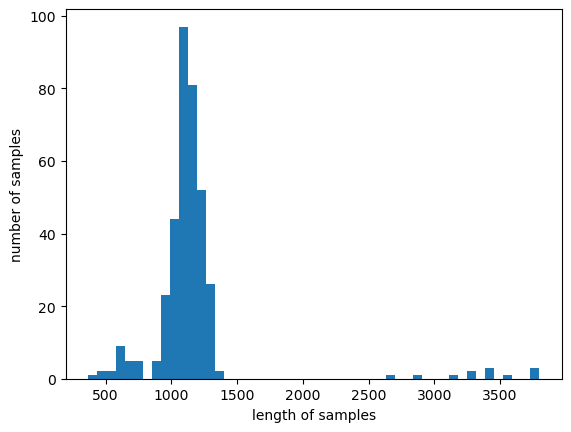

In [12]:
print('문서의 최대 길이 :',max(len(document) for document in documents))
print('문서의 최소 길이 :',min(len(document) for document in documents))
print('문서의 평균 길이 :',sum(map(len, documents))/len(documents))
plt.hist([len(review) for review in documents], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [13]:
# 0번 문서는 머리말
texts[0].page_content

'iii\n찾아보기\n한국은행은 국민들이 경제 및 금융에 대한 이해도를 높이고 경제에 관한 합리적인 \n의사결정 능력을 키울 수 있도록 현장 경제교육, 온라인 경제교육, 경제교육 콘텐츠 \n개발 등 대국민 경제교육을 다양하게 수행해 오고 있습니다 . \n이의 일환으로 2018년 \n 경제금융용어 700선\n 을 발간하였는데 그간 동 책자에 대한 \n수요가 꾸준히 늘어남에 따라 이번에 추가로 발간하게 되었습니다 .\n지난번 내용과 같이 통화정책, 실물경제, 금융안정, 지급결제 등 한국은행 주요 \n업무를 이해하는데 필요한 전문 용어와 경제·금융 흐름을 이해하는데 도움이 되는 \n시사 경제금융 용어들을 수록하였습니다. 용어해설은 개념과 도입 배경, 의미, 적용 \n사례 등을 담아 쉽게 이해할 수 있도록 하였습니다. 또한 e-book으로도 제작하여 \n독자들의 편의성과 가독성을 높였습니다 . \n코로나 19로 이전에 경험하지 못한 경제위기를 겪으면서 경제·금융 현상에 대한 \n일반인들의 관심도가 이전에 비해 높아졌습니다. 아무쪼록 이 책자가 한국은행의 주요 \n정책과 국내외 경제를 이해하는 데 조금이나마 도움이 되기를 바라겠습니다. 끝으로 \n경제금융용어 700선\n  집필에 참여해주신 경제교육실 교수님들과 용어 집필에 좋은 \n의견을 주신 관련부서 여러분께 감사드립니다 .\n2020년 8월\n한국은행 경제교육실장 박 철 원\n머 리 말'

In [14]:
texts[5].page_content

'vi\n경제금융용어 700선\nㅂ\n바이오인증 ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・118\n바젤은행감독위원회/\n바젤위원회(BCBS) ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・118\n발행시장 ・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・119\n발행중지화폐/유통정지화폐 ・・・・・・・・・・・・・・・120\n방카슈랑스 ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・120\n배당할인모형 ・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・121\n밴드웨건효과 ・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・121\n뱅 크 런 ・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・122\n범위의 경제 ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・122\n법률리스크 ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・122\n베블런효과 ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・123\n변동금리 ・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・123\n변동금리부채권(FRN) ・ ・ ・・・・・・・・・・・・・・・・・・・・・・・123\n보기화폐(견양화폐) ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・124\n보완자본(

In [15]:
# 12번 문서까지는 목차
texts[12].page_content

'xiii\n찾아보기❙\n환매조건부매매/RP/Repo ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・331\n환 어 음 ・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・332\n환율조작국 ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・332\n환전영업자(환전상) ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・333\n환차손/환차익 ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・333\n황금낙하산 ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・ ・334\n회 사 채 ・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・334\n회수의문 ・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・335\n후방연쇄효과 ・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・335\n후순위금융채 ・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・335\n후행종합지수 ・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・336\nABC\nB e y o n d  G D P ・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・337\nBIS 자기자본비율 ・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・338\nCAMEL-R시스템/ROCA시스템/\nC A C R E L 시 스 템 ・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・338\nC L S 은 행 ・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・339\nC 

In [16]:
# 13번 문서부터는 금융 용어 설명
texts[13].page_content

"1\nㄱ \nㄱ\n가계부실위험지수(HDRI)\n가구의 소득 흐름은 물론 금융 및 실물 자산까지 종합적으로 고려하여 가계부채의 \n부실위험을 평가하는 지표로, 가계의 채무상환능력을 소득 측면에서 평가하는 원리금상\n환비율(DSR; Debt Service Ratio)과 자산 측면에서 평가하는 부채/자산비율(DTA; Debt \nTo Asset Ratio)을 결합하여 산출한 지수이다. 가계부실위험지수는 가구의 DSR과 DTA가 \n각각 40%, 100%일 때 100의 값을 갖도록 설정되어 있으며, 동 지수가 100을 초과하는 \n가구를 ‘위험가구’로 분류한다. 위험가구는 소득 및 자산 측면에서 모두 취약한 ‘고위험가구’, \n자산 측면에서 취약한 ‘고DTA가구’, 소득 측면에서 취약한 ‘고DSR가구’로 구분할 수 있다. \n다만 위험 및 고위험 가구는 가구의 채무상환능력 취약성 정도를 평가하기 위한 것이며 \n이들 가구가 당장 채무상환 불이행, 즉 임계상황에 직면한 것을 의미하지 않는다 .\n 연관검색어 : 총부채원리금상환비율(DSR)\n가계수지\n가정에서 일정 기간의 수입(명목소득)과 지출을 비교해서 남았는지 모자랐는지를 \n표시한 것을 가계수지(household's total income and expenditure)라 한다. 가계수지가 \n가계수지 ∙"

참고로 \n은 줄바꿈 문자입니다. 쉽게 설명하면 Enter에 해당하므로 크게 신경쓰지 않아도 됩니다. print()로 출력해보면 알 수 있습니다.

In [17]:
print(texts[13].page_content)

1
ㄱ 
ㄱ
가계부실위험지수(HDRI)
가구의 소득 흐름은 물론 금융 및 실물 자산까지 종합적으로 고려하여 가계부채의 
부실위험을 평가하는 지표로, 가계의 채무상환능력을 소득 측면에서 평가하는 원리금상
환비율(DSR; Debt Service Ratio)과 자산 측면에서 평가하는 부채/자산비율(DTA; Debt 
To Asset Ratio)을 결합하여 산출한 지수이다. 가계부실위험지수는 가구의 DSR과 DTA가 
각각 40%, 100%일 때 100의 값을 갖도록 설정되어 있으며, 동 지수가 100을 초과하는 
가구를 ‘위험가구’로 분류한다. 위험가구는 소득 및 자산 측면에서 모두 취약한 ‘고위험가구’, 
자산 측면에서 취약한 ‘고DTA가구’, 소득 측면에서 취약한 ‘고DSR가구’로 구분할 수 있다. 
다만 위험 및 고위험 가구는 가구의 채무상환능력 취약성 정도를 평가하기 위한 것이며 
이들 가구가 당장 채무상환 불이행, 즉 임계상황에 직면한 것을 의미하지 않는다 .
 연관검색어 : 총부채원리금상환비율(DSR)
가계수지
가정에서 일정 기간의 수입(명목소득)과 지출을 비교해서 남았는지 모자랐는지를 
표시한 것을 가계수지(household's total income and expenditure)라 한다. 가계수지가 
가계수지 ∙


#### 앞에 몇 개의 문서를 출력해본 결과 0번 문서는 머리말, 12번 문서까지는 목차, 13번 문서부터 금융 용어를 설명하는 문서임을 확인하였습니다. 
#### 다시 말해 용어를 검색을 위해서는 0번 문서부터 12번 문서는 필요가 없을 것입니다. 기존의 0번 문서와 12번 문서를 제거해보겠습니다.

In [26]:
# 앞에서 0~12번까지 전부 삭제
texts = texts[13:]
print('줄어든 texts의 길이 :', len(texts))

줄어든 texts의 길이 : 353


#### 현재의 0번 문서를 출력해보겠습니다. 전처리가 제대로 되었다면 이전의 13번 문서가 현재의 0번 문서가 되어야 합니다.

In [27]:
print('첫번째 문서 출력 :', texts[0])

첫번째 문서 출력 : page_content='1
ㄱ 
ㄱ
가계부실위험지수(HDRI)
가구의 소득 흐름은 물론 금융 및 실물 자산까지 종합적으로 고려하여 가계부채의 
부실위험을 평가하는 지표로, 가계의 채무상환능력을 소득 측면에서 평가하는 원리금상
환비율(DSR; Debt Service Ratio)과 자산 측면에서 평가하는 부채/자산비율(DTA; Debt 
To Asset Ratio)을 결합하여 산출한 지수이다. 가계부실위험지수는 가구의 DSR과 DTA가 
각각 40%, 100%일 때 100의 값을 갖도록 설정되어 있으며, 동 지수가 100을 초과하는 
가구를 ‘위험가구’로 분류한다. 위험가구는 소득 및 자산 측면에서 모두 취약한 ‘고위험가구’, 
자산 측면에서 취약한 ‘고DTA가구’, 소득 측면에서 취약한 ‘고DSR가구’로 구분할 수 있다. 
다만 위험 및 고위험 가구는 가구의 채무상환능력 취약성 정도를 평가하기 위한 것이며 
이들 가구가 당장 채무상환 불이행, 즉 임계상황에 직면한 것을 의미하지 않는다 .
 연관검색어 : 총부채원리금상환비율(DSR)
가계수지
가정에서 일정 기간의 수입(명목소득)과 지출을 비교해서 남았는지 모자랐는지를 
표시한 것을 가계수지(household's total income and expenditure)라 한다. 가계수지가 
가계수지 ∙' metadata={'producer': 'Smart PDF Imposition 1.0', 'creator': 'Smart PDF Imposition 1.0', 'creationdate': 'January 31, 2018 16:21', 'author': 'INSUNG DATA INC.', 'creationdate--text': 'January 31, 2018 16:21', 'moddate': 'January 31, 2018 16:21', 'moddate--text': 'January 31, 2018 16:21', 'subject': 'CoreImposition PDF 1.0 Output', 'ti

#### 이번에는 마지막 데이터를 확인해봅시다. 해당 문서에 대한 맺음말에 해당되므로 해당 데이터도 불필요합니다.

In [28]:
texts[-1]

Document(metadata={'producer': 'Smart PDF Imposition 1.0', 'creator': 'Smart PDF Imposition 1.0', 'creationdate': 'January 31, 2018 16:21', 'author': 'INSUNG DATA INC.', 'creationdate--text': 'January 31, 2018 16:21', 'moddate': 'January 31, 2018 16:21', 'moddate--text': 'January 31, 2018 16:21', 'subject': 'CoreImposition PDF 1.0 Output', 'title': '°æÁ¦±ÝÀ¶¿ë¾î 700¼±-ÃÖÁ¾.PDF', 'source': '2020_경제금융용어 700선_게시.pdf', 'total_pages': 371, 'page': 369, 'page_label': '370'}, page_content='경제금융용어 700선\n발행인 이주열\n편집인 박철원\n발행처 한국은행(www.bok.or.kr)\n서울특별시 중구 세종대로 67(태평로 2가)\n발행일 2020년 8월 3일\n인  쇄 ㈜제일프린테크 \n 본 자료는 한국은행 홈페이지(http://www.bok.or.kr>경제교육>온라인학습>일반인) 에서 \n다운로드 받으실 수 있습니다.\n 이 책자에 대한 문의는 한국은행 경제교육실 경제교육기획팀(02-759-5618)으로 연락 \n하여 주시기 바랍니다.\n \n 경제금융용어 700선\n 은 \n① 정부간행물판매센터(☎ 02-734-6818, http://www.gpcbooks.co.kr) \n② 한국경제서적(☎ 02-737-7498)\n③ 경제서적(☎ 02-736-0640, http://kj-book.co.kr) 또는 주요 서점 등에서 매권당 \n8,000원에 판매하고 있습니다.\nISBN 979-11-5538-393-3 03320')

#### 뒤에서 두번째 데이터를 확인해봅시다.

In [29]:
texts[-2]

Document(metadata={'producer': 'Smart PDF Imposition 1.0', 'creator': 'Smart PDF Imposition 1.0', 'creationdate': 'January 31, 2018 16:21', 'author': 'INSUNG DATA INC.', 'creationdate--text': 'January 31, 2018 16:21', 'moddate': 'January 31, 2018 16:21', 'moddate--text': 'January 31, 2018 16:21', 'subject': 'CoreImposition PDF 1.0 Output', 'title': '°æÁ¦±ÝÀ¶¿ë¾î 700¼±-ÃÖÁ¾.PDF', 'source': '2020_경제금융용어 700선_게시.pdf', 'total_pages': 371, 'page': 368, 'page_label': '369'}, page_content='352\n경제금융용어 700선\n와 관련된 다양한 부수업무를 하는 회사를 말한다. 가령 신용카드 거래가 발생하면 \nVAN사업자는 거래 승인을 위해 신용카드사에 거래내역을 전송하고 승인 및 조회결과를 \n수신한 후 이를 가맹점에 전송한다. 또한 VAN사업자는 가맹점이 신용카드사에 전표를 \n제출하여 대금을 청구하는 업무를 대신하기 위하여 가맹점을 방문하여 전표실물을 수거\n하거나 전표 데이터를 수집한다 . \n 연관검색어 : 지급결제시스템, 전자금융\nVaR(Value at Risk) \n주어진 신뢰수준 하에서 일정 기간 동안 발생할 수 있는 ‘최대 손실금액’으로 금융기관\n의 잠재적인 손실을 측정하는 지표이다. 예를 들어 목표기간 1년, 신뢰수준 95% 에서 \n산출된 VaR가 10억 원이라면 이는 1년 동안 발생할 수 있는 손실금액이 10억 원보다 \n작을 확률이 95%라는 것을 의미한다 . \n 연관검색어 : 예상손실\nVIX\n미국 주식시장의 단기 변동성에 대한 시장의 기대치를 나타내는 지수로 시

마지막 데이터를 제거 후에 개수를 출력해봅시다.

In [30]:
# 마지막 데이터를 제거
texts = texts[:-1]
print('마지막 데이터 제거 후 texts의 길이 :', len(texts))

마지막 데이터 제거 후 texts의 길이 : 352


#### 이제 데이터의 개수가 1개 줄어들었습니다. 이제 마지막 데이터를 출력하면 앞서 출력되었던 뒤에서 두번째 데이터가 출력되어야 합니다.

In [31]:
print('마지막 데이터 출력')
texts[-1]

마지막 데이터 출력


Document(metadata={'producer': 'Smart PDF Imposition 1.0', 'creator': 'Smart PDF Imposition 1.0', 'creationdate': 'January 31, 2018 16:21', 'author': 'INSUNG DATA INC.', 'creationdate--text': 'January 31, 2018 16:21', 'moddate': 'January 31, 2018 16:21', 'moddate--text': 'January 31, 2018 16:21', 'subject': 'CoreImposition PDF 1.0 Output', 'title': '°æÁ¦±ÝÀ¶¿ë¾î 700¼±-ÃÖÁ¾.PDF', 'source': '2020_경제금융용어 700선_게시.pdf', 'total_pages': 371, 'page': 368, 'page_label': '369'}, page_content='352\n경제금융용어 700선\n와 관련된 다양한 부수업무를 하는 회사를 말한다. 가령 신용카드 거래가 발생하면 \nVAN사업자는 거래 승인을 위해 신용카드사에 거래내역을 전송하고 승인 및 조회결과를 \n수신한 후 이를 가맹점에 전송한다. 또한 VAN사업자는 가맹점이 신용카드사에 전표를 \n제출하여 대금을 청구하는 업무를 대신하기 위하여 가맹점을 방문하여 전표실물을 수거\n하거나 전표 데이터를 수집한다 . \n 연관검색어 : 지급결제시스템, 전자금융\nVaR(Value at Risk) \n주어진 신뢰수준 하에서 일정 기간 동안 발생할 수 있는 ‘최대 손실금액’으로 금융기관\n의 잠재적인 손실을 측정하는 지표이다. 예를 들어 목표기간 1년, 신뢰수준 95% 에서 \n산출된 VaR가 10억 원이라면 이는 1년 동안 발생할 수 있는 손실금액이 10억 원보다 \n작을 확률이 95%라는 것을 의미한다 . \n 연관검색어 : 예상손실\nVIX\n미국 주식시장의 단기 변동성에 대한 시장의 기대치를 나타내는 지수로 시

### 정리해봅시다. PyPDFLoader가 PDF에서 각 페이지 별로 로드하여 다수의 문서로 만들었습니다.

1. 문서의 형태를 확인하였습니다. 형식은 page_content에는 분할된 텍스트의 본문이 저장되어져 있고, source에는 해당 본문의 원본 파일의 이름이 저장되어져 있습니다.  
2. PDF 페이지 371 -> 문서의 개수가 366개로 줄었다는 것은 이미지는 로드 안 하고 텍스트만 로드한 것입니다.
3. 길이 분포를 시각화하고, 또 최대 길이, 최소 길이, 평균 길이를 계산하여 지나치게 짧거나 지나치게 긴 문서가 없는지 확인했습니다.  
4. 앞의 문서와 뒤의 문서는 머리말과 맺음말인 것을 PDF 파일을 통해 확인하였으므로 실제 출력을 통해 머리말과 맺음말, 목차의 위치를 확인하고 해당 파일들을 제거하였습니다.  

결과적으로 366개의 데이터는 352개의 데이터가 되었습니다.  
이제 형식을 이해하였으며 352개의 금융 문서가 있음을 알았습니다.

## **필요 데이터 전처리**

OpenAI Embedding API를 이용하여 텍스트를 임베딩하고, 코사인 유사도를 통해 유사한 텍스트를 가져오는 실습을 진행한 바 있습니다. 여기서는 OpenAI의 Embedding API를 사용합니다. 일반적으로 OpenAI Embedding API가 sentence_transformer 라이브러리를 이용하는 것보다 성능이 더 뛰어납니다.

Chroma DB는 이 과정들을 기능 별로 이미 구현하여 사용자가 벡터를 좀 더 쉽게 다룰 수 있도록 도와주는 편리한 벡터 응용 도구입니다. 일반적으로 Embedding하여 벡터들 간의 유사도를 구할 때에는 Vector DB라는 것을 사용합니다.  
Chroma.from_documents()를 통해 벡터 도구 객체를 선언합니다. 이때 documents에는 벡터화의 단위가 될 텍스트 리스트를 매개변수로 사용하고, embedding에는 어떤 종류의 임베딩을 사용할 것인지를 기재해줍니다.

크로마 사용 방법: https://python.langchain.com/docs/integrations/vectorstores/chroma  

위 링크에서 아래에 보면 'Use OpenAI Embeddings'라고 해서 OpenAI Embedding을 사용하는 경우의 예시도 나와있습니다.

In [32]:
# 모델명 같은 걸 안적었는데..?!
# 안적으면 text-embedding-ada-002 모델이 default
embedding = OpenAIEmbeddings()

# Chroma.from_documents(documents='우리가 넣을 문서들', embedding='우리가 사용할 임베딩 모델')
vectordb = Chroma.from_documents(documents=texts, embedding=embedding)

C:\Users\user\AppData\Local\Temp\ipykernel_23252\3004704302.py:3: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding = OpenAIEmbeddings()


#### vectordb를 선언하고 나면 그 후에는 '_collection' 다음에 온점을 찍고 다양한 함수들을 사용할 수 있습니다. 
#### 예를 들어 count()는 현재 저장된 문서 또는 벡터 개수를 의미합니다.

#### 벡터 DB는 종류가 많다. 여기서는 Chroma라는 vectorDB를 사용하고 있다.

In [33]:
# 벡터DB의 개수 확인
vectordb._collection.count()

352

#### 기본적으로 `_collection.get()`은 현재 vectordb에 저장된 값들을 볼 수 있게 하는 기능을 갖고 있습니다. 
#### 어떤 값들을 호출할 수 있는지 확인해봅시다.

In [ ]:
# vectordb._collection.get()

In [34]:
for key in vectordb._collection.get():
  print(key)

ids
embeddings
documents
uris
data
metadatas
included


#### ids, embeddings, metadatas, documents를 호출할 수 있습니다. 
#### vectordb에 저장된 기존 문서들을 보고 싶다면 '['documents']'를 통해 불러올 수 있습니다.

In [35]:
# 문서 로드
documents = vectordb._collection.get()['documents']
print('문서의 개수 :', len(documents))
print('-' * 100)
print('첫번째 문서 출력 :', documents[0])

문서의 개수 : 352
----------------------------------------------------------------------------------------------------
첫번째 문서 출력 : 1
ㄱ 
ㄱ
가계부실위험지수(HDRI)
가구의 소득 흐름은 물론 금융 및 실물 자산까지 종합적으로 고려하여 가계부채의 
부실위험을 평가하는 지표로, 가계의 채무상환능력을 소득 측면에서 평가하는 원리금상
환비율(DSR; Debt Service Ratio)과 자산 측면에서 평가하는 부채/자산비율(DTA; Debt 
To Asset Ratio)을 결합하여 산출한 지수이다. 가계부실위험지수는 가구의 DSR과 DTA가 
각각 40%, 100%일 때 100의 값을 갖도록 설정되어 있으며, 동 지수가 100을 초과하는 
가구를 ‘위험가구’로 분류한다. 위험가구는 소득 및 자산 측면에서 모두 취약한 ‘고위험가구’, 
자산 측면에서 취약한 ‘고DTA가구’, 소득 측면에서 취약한 ‘고DSR가구’로 구분할 수 있다. 
다만 위험 및 고위험 가구는 가구의 채무상환능력 취약성 정도를 평가하기 위한 것이며 
이들 가구가 당장 채무상환 불이행, 즉 임계상황에 직면한 것을 의미하지 않는다 .
 연관검색어 : 총부채원리금상환비율(DSR)
가계수지
가정에서 일정 기간의 수입(명목소득)과 지출을 비교해서 남았는지 모자랐는지를 
표시한 것을 가계수지(household's total income and expenditure)라 한다. 가계수지가 
가계수지 ∙


In [36]:
# embedding 호출 시도
result = vectordb._collection.get()['embeddings']
print(result)

None


#### embedding 벡터의 값은 기본적으로는 제공하지 않는다.
#### 때문에 embedding 벡터의 값도 확인하고 싶다면 get() 호출 시 내부에 include=['embeddings']를 함께 호출해야 합니다. 
#### 그 후 ['embeddings']를 통해 호출할 수 있습니다.

In [37]:
# embedding vetor만 조회하기
embeddings = vectordb._collection.get(include=['embeddings'])['embeddings']
print('임베딩 벡터의 개수 :', len(embeddings))

임베딩 벡터의 개수 : 352


In [38]:
print('첫번째 문서의 임베딩 값 출력 :', embeddings[0])
print('첫번째 문서의 임베딩 값의 길이 :', len(embeddings[0]))

첫번째 문서의 임베딩 값 출력 : [-0.0077088  -0.0075166   0.014182   ... -0.01861645 -0.00669286
 -0.00903364]
첫번째 문서의 임베딩 값의 길이 : 1536


In [42]:
print('두번째 문서의 임베딩 값 출력 :', embeddings[1])
# 같은 모델의 임베딩 길이는 모두 같다.
print('두번째 문서의 임베딩 값의 길이 :', len(embeddings[1]))

두번째 문서의 임베딩 값 출력 : [ 0.00170697 -0.01484938  0.03096656 ...  0.00016448 -0.00243612
 -0.01603626]
두번째 문서의 임베딩 값의 길이 : 1536


#### 이번에는 metadatas를 호출해봅시다. 참고로 metadatas는 각 문서의 출처를 의미합니다.

In [39]:
metadatas = vectordb._collection.get()['metadatas']
print('metadatas의 개수 :', len(metadatas))
print('첫번째 문서의 출처 :', metadatas[0])

metadatas의 개수 : 352
첫번째 문서의 출처 : {'author': 'INSUNG DATA INC.', 'creationdate': 'January 31, 2018 16:21', 'creationdate--text': 'January 31, 2018 16:21', 'creator': 'Smart PDF Imposition 1.0', 'moddate': 'January 31, 2018 16:21', 'moddate--text': 'January 31, 2018 16:21', 'page': 17, 'page_label': '18', 'producer': 'Smart PDF Imposition 1.0', 'source': '2020_경제금융용어 700선_게시.pdf', 'subject': 'CoreImposition PDF 1.0 Output', 'title': '°æÁ¦±ÝÀ¶¿ë¾î 700¼±-ÃÖÁ¾.PDF', 'total_pages': 371}


#### 벡터 도구 객체를 선언하고 나면 as_retriever()를 통해서 입력된 텍스트로부터 유사한 텍스트를 찾아주는 retriever를 선언할 수 있습니다. 
#### retriever를 선언 후 get_relevant_documents()를 통해 입력된 텍스트와 유사한 문서들을 찾아서 반환합니다. 
#### 앞서 실전 모델링2에서 실습했던 벡터의 유사도를 구하는 과정을 별도의 추가 구현없이 손쉽게 사용할 수 있습니다. 
#### 여기서도 내부적으로 코사인 유사도를 수행하고 있습니다.

In [40]:
# 유사도가 높은 문서 2개만 추출. k = 2
retriever = vectordb.as_retriever(search_kwargs={"k": 2})

In [44]:
docs = retriever.get_relevant_documents("비트코인이 궁금해")
print('유사 문서 개수 :', len(docs))
print('--' * 20)
print('첫번째 유사 문서 :', docs[0])
print('--' * 20)
print('두번째 유사 문서 :', docs[1])

유사 문서 개수 : 2
----------------------------------------
첫번째 유사 문서 : page_content='139
ㅂ 
비트코인
비트코인(bitcoin)은 가상통화(암호통화)이자 디지털 지급시스템이다. 비트코인 시스템
은 중앙 저장소 또는 단일 관리자가 없기 때문에 최초의 탈중앙화된 디지털통화라고 불린다. 
이는 사토시 나카모토라는 사람(집단)에 의해 만들어져서 2009년 개방형 소프트웨어로 
배포되었다. 이 시스템은 공유형(peer-to-peer)이며, 거래는 중개자 없이 블록체인 소프트
웨어를 이용하는 참여자(nodes) 사이에 직접 이뤄진다. 이런 거래들은 공유(P2P) 네트워크
상 참여자의 작업증명(proof-of-work)을 통해 검증되고 공개된 분산원장인 블록체인에 
기록된다. 승인된 거래의 새 그룹인 한 블록은 대략 10분에 한 번씩 만들어져서 블록체인에 
추가되고 신속하게 모든 참여자에게 보내어진다. 비트코인은 대규모 전기를 사용하는 
컴퓨터 처리 능력(power)을 활용해서 이뤄지는 기록보관 서비스인 채굴(mining)에 대한 
보상으로 발행되고 있으며 다른 통화･상품･용역 등과 교환되어가고 있다. 중앙은행이 
발행한 법정화폐가 아닌 비트코인은 비트코인 플랫폼에서 거래되며 투자대상으로서도 
관심을 받고 있다. 하지만 급등한 가격 및 심한 변동 폭으로 거품논란이 크다. 또한 익명성으
로 자금세탁 등 불법거래에 악용될 소지가 많아 중국 등 일부 국가에서 비트코인 등 가상통
화의 거래를 규제하고 있다. 일본의 경우 비트코인의 거래이익에 대해 세금을 부과한다. 
비트코인은 추가되는 한 블록당 새로 12.5비트코인을 보상하는데(2016.7월 현재), 21만개
가 채굴될 때(대략 4년)마다 그 보상이 반으로 줄어든다. 비트코인의 총량은 21백만개이며 
2140년경 모두 채굴될 것으로 전망된다. 비트코인은 그 시스템의 설계시 그 수량을 한정시
켜 놓았기 때문에 원칙적으로 인플레이션에 의해 가치가 떨어질 수 있는 화폐와 다

이제 ChatGPT API와 이미 만들어진 Prompt를 통해서 간단히 챗봇을 구현해봅시다. RetrievalQA.from_chain_type()의 llm 매개변수의 값으로 초기에 임포트한 OpenAI()를 사용할 경우, 기본값으로 ChatGPT API를 사용합니다.chain_type의 매개변수의 값으로 "stuff"를 사용할 경우, 사용자의 눈에는 보이지 않지만 자동으로 아래의 프롬프트를 사용하여 챗봇을 구현합니다.  

해석해보면 주어진 질문과 본문을 통해서 답변을 하되, 만약 답변할 수 없다면 답변을 임의로 하지말고 모른다고 하라는 내용입니다.
```
Use the following pieces of context to answer the users question.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
----------------
{텍스트}

{질문}
```

{텍스트}에는 사용자의 질문으로부터 높은 유사도를 가진 텍스트가 들어가게 되고, {질문} 부분은 사용자의 질문이 들어가게 됩니다. retriever는 입력된 사용자의 질문으로부터 유사도를 계산하는 도구를 구현하여 매개변수의 값으로 넘겨주면 됩니다. 앞서 이미 Chroma를 통해 벡터 도구 객체로부터 구현한 retreiver를 사용합니다.  

return_source_documents는 챗봇의 답변에 사용된 텍스트들의 출처를 표시할 것인지를 의미합니다. return_source_documents의 값을 False로 할 경우, 챗봇의 답변이 어떤 텍스트에 근거하였는지 알 수 없습니다. 여기서는 뒤에서 근거가 되는 텍스트의 출처를 확인할 것이므로 True를 사용합니다.

만약 프롬프트를 직접 작성하고 싶다면 아래의 문서를 참고하세요.  

https://python.langchain.com/docs/use_cases/question_answering/how_to/vector_db_qa#custom-prompts

In [45]:
from langchain import PromptTemplate

# Create Prompt
template = """당신은 한국은행에서 만든 금융 용어를 설명해주는 금융쟁이입니다.
안상준 개발자가 만들었습니다. 주어진 검색 결과를 바탕으로 답변하세요.
검색 결과에 없는 내용이라면 답변할 수 없다고 하세요. 반말로 친근하게 답변하세요.
{context}

Question: {question}
Answer:
"""

prompt = PromptTemplate.from_template(template)

In [46]:
# Streaming
# llm = ChatOpenAI(model_name="gpt-4o", streaming=True, temperature=0, callbacks=[StreamingStdOutCallbackHandler()])

# Streaming을 하지 않는 경우
llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm, # 답변에 쓸 LLM
    chain_type_kwargs={"prompt": prompt}, # 프롬프트 템플릿
    # chain_type="stuff", 기본 프롬프트를 사용하는 경우
    retriever=retriever, # vectorDB
    return_source_documents=True) # 검색된 문서 출력 여부 (default=false)

문서의 개수 : 352
문서의 최대 길이 : 1378
문서의 최소 길이 : 369
문서의 평균 길이 : 1093.9318181818182


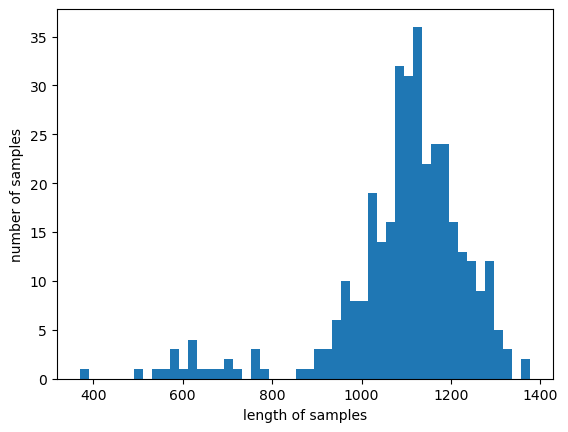

In [47]:
documents = vectordb._collection.get()['documents']
print('문서의 개수 :', len(documents))
print('문서의 최대 길이 :',max(len(document) for document in documents))
print('문서의 최소 길이 :',min(len(document) for document in documents))
print('문서의 평균 길이 :',sum(map(len, documents))/len(documents))
plt.hist([len(review) for review in documents], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

이제 qa_chain을 통해 사용자의 입력으로부터 서울 청년 정책과 관련된 챗봇의 답변을 얻을 수 있습니다. 임의의 "디커플링이란 무엇인가?"라는 텍스트를 입력하여 qa_chain의 반환 결과를 확인해봅시다.

In [48]:
input_text = "디커플링이란 무엇인가?"
chatbot_response = qa_chain(input_text)

C:\Users\user\AppData\Local\Temp\ipykernel_23252\4005104770.py:2: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  chatbot_response = qa_chain(input_text)


In [49]:
chatbot_response

{'query': '디커플링이란 무엇인가?',
 'result': '디커플링은 어떤 나라나 지역의 경제가 인접한 다른 국가나 전반적인 세계 경제의 흐름과는 다른 모습을 보이는 현상을 말해. 예를 들어, 금융위기 이후 신흥국가나 유로지역 국가들이 미국 경제와 다른 모습을 보이는 경우가 있어. 주가나 금리, 환율 등 일부 경제 변수의 흐름이 국가 간 또는 특정 국가 내에서 서로 다른 흐름을 보이는 것도 디커플링이라고 할 수 있어. 반대로, 경제가 다른 국가나 세계 경제 흐름과 유사한 흐름을 보이는 것을 커플링이라고 해.',
 'source_documents': [Document(metadata={'author': 'INSUNG DATA INC.', 'creationdate': 'January 31, 2018 16:21', 'creationdate--text': 'January 31, 2018 16:21', 'creator': 'Smart PDF Imposition 1.0', 'moddate': 'January 31, 2018 16:21', 'moddate--text': 'January 31, 2018 16:21', 'page': 114, 'page_label': '115', 'producer': 'Smart PDF Imposition 1.0', 'source': '2020_경제금융용어 700선_게시.pdf', 'subject': 'CoreImposition PDF 1.0 Output', 'title': '°æÁ¦±ÝÀ¶¿ë¾î 700¼±-ÃÖÁ¾.PDF', 'total_pages': 371}, page_content='98\n경제금융용어 700선\n가계와 기업이 소비와 투자를 미룸으로써 수요의 위축을 초래하여 디플레이션 압력을 \n보다 크게 할 수도 있다. 이 같은 상황에서는 경제주체들의 물가상승률 예상치가 더 \n낮아지지 않도록 사전에 통화 ･재정정책 면에서 적극적으로 대응하는 것이 중요하다 .\n 연관검색어 : 디플레이션,  통화정책\n디커플링/커플링\n디커플

In [51]:
# 실제 검색된 문서
chatbot_response['source_documents']

[Document(metadata={'author': 'INSUNG DATA INC.', 'creationdate': 'January 31, 2018 16:21', 'creationdate--text': 'January 31, 2018 16:21', 'creator': 'Smart PDF Imposition 1.0', 'moddate': 'January 31, 2018 16:21', 'moddate--text': 'January 31, 2018 16:21', 'page': 114, 'page_label': '115', 'producer': 'Smart PDF Imposition 1.0', 'source': '2020_경제금융용어 700선_게시.pdf', 'subject': 'CoreImposition PDF 1.0 Output', 'title': '°æÁ¦±ÝÀ¶¿ë¾î 700¼±-ÃÖÁ¾.PDF', 'total_pages': 371}, page_content='98\n경제금융용어 700선\n가계와 기업이 소비와 투자를 미룸으로써 수요의 위축을 초래하여 디플레이션 압력을 \n보다 크게 할 수도 있다. 이 같은 상황에서는 경제주체들의 물가상승률 예상치가 더 \n낮아지지 않도록 사전에 통화 ･재정정책 면에서 적극적으로 대응하는 것이 중요하다 .\n 연관검색어 : 디플레이션,  통화정책\n디커플링/커플링\n디커플링(decoupling)이란 탈동조화라고 번역할 수 있는데, 어떤 나라나 지역의 경제\n가 인접한 다른 국가나 전반적인 세계 경제의 흐름과는 다른 모습을 보이는 현상을 \n말한다. 최근의 디커플링의 예로는 금융위기 이후 신흥국가나 유로지역 국가 등이 특히 \n미국 경제와 다른 모습을 보이는 것을 들 수 있다. 이외에도 주가나 금리, 환율 등 \n일부 경제 변수의 흐름이 국가 간 또는 특정국가내에서 서로 다른 흐름을 보이는 현상도 \n디커플링이라고 할 수 있다. 국가 간의 경우 미국의 주가와 한국의 주가가 다른 방향으로 \n움직이거나, 한 국가 내에서의 경우 

이번에는 경제금융용어 700선 파일로는 알 수 없는 정보를 물어보겠습니다.

In [57]:
input_text = "23년 9월달의 서울 집값 추이를 알려주세요"
chatbot_response = qa_chain(input_text)

In [58]:
chatbot_response

{'query': '23년 9월달의 서울 집값 추이를 알려주세요',
 'result': '미안한데, 23년 9월달의 서울 집값 추이에 대한 정보는 제공할 수 없어. 다른 금융 용어에 대해 궁금한 게 있으면 물어봐!',
 'source_documents': [Document(metadata={'author': 'INSUNG DATA INC.', 'creationdate': 'January 31, 2018 16:21', 'creationdate--text': 'January 31, 2018 16:21', 'creator': 'Smart PDF Imposition 1.0', 'moddate': 'January 31, 2018 16:21', 'moddate--text': 'January 31, 2018 16:21', 'page': 65, 'page_label': '66', 'producer': 'Smart PDF Imposition 1.0', 'source': '2020_경제금융용어 700선_게시.pdf', 'subject': 'CoreImposition PDF 1.0 Output', 'title': '°æÁ¦±ÝÀ¶¿ë¾î 700¼±-ÃÖÁ¾.PDF', 'total_pages': 371}, page_content='49\nㄱ \n금의 일시 보전을 위해 ｢국고금관리법｣에 의해 발행되는데 만기는 1년 이내지만 실제로\n는 3개월 이내이며 경쟁입찰방식으로 발행된다. 국민주택채권은 국민주택건설 재원조달\n을 위해 ｢주택도시기금법｣에 의해 부동산 등기 및 인허가와 관련하여 의무적으로 매입하\n도록 하는 첨가소화방식으로 발행되며 만기는 5년이다. 보상채권은 공공용지 보상비 \n마련을 위하여 ｢공익사업을 위한 토지 등의 취득 및 보상에 관한 법률｣에 의해 당사자앞 \n교부방식으로 발행되며 만기는 5년 이내지만 실제로는 3년 만기로 발행한다 . \n규모의 경제\n일반적인 경우 기업이 재화 및 서비스 생산량을 늘려감에 따라 추가적으로 소요되는 \n평균 생산비용도 점차 늘어난다. 그

In [54]:
chatbot_response['result']

'미안하지만, 23년 9월달의 서울 집값 추이에 대한 정보는 제공할 수 없어. 다른 금융 용어에 대해 궁금한 게 있으면 물어봐!'

In [55]:
input_text = "너는 누가 만든거야?"
chatbot_response = qa_chain(input_text)

In [56]:
chatbot_response

{'query': '너는 누가 만든거야?',
 'result': '안상준 개발자가 만들었어.',
 'source_documents': [Document(metadata={'author': 'INSUNG DATA INC.', 'creationdate': 'January 31, 2018 16:21', 'creationdate--text': 'January 31, 2018 16:21', 'creator': 'Smart PDF Imposition 1.0', 'moddate': 'January 31, 2018 16:21', 'moddate--text': 'January 31, 2018 16:21', 'page': 253, 'page_label': '254', 'producer': 'Smart PDF Imposition 1.0', 'source': '2020_경제금융용어 700선_게시.pdf', 'subject': 'CoreImposition PDF 1.0 Output', 'title': '°æÁ¦±ÝÀ¶¿ë¾î 700¼±-ÃÖÁ¾.PDF', 'total_pages': 371}, page_content='237\nㅈ \n자유재\n희소성이 높지 않고 아무런 대가를 치르지 않아도 무상으로 얻을 수 있는 재화를 \n말한다. 이는 희소성을 가지며 경제적 거래를 통해 얻을 수 있는 경제재 (economic \ngoods)의 반대 개념이다. 자유재(free goods)는 대가를 치르지 않고서도 얼마든지 원하\n는 만큼 얻을 수 있기 때문에 경제문제를 일으키지 않으며 희소성의 원칙도 적용되지 \n않는다. 현실세계에서 자유재는 매우 드물다. 공기, 물, 햇빛 등이 전통적으로 자유재로 \n고려되었으나 양질의 생수를 높은 비용으로 구매하고, 맑은 공기를 마시기 위하여 휴양림\n을 찾아가는 등 기존에 자유재로 고려되던 재화들이 상황 변화에 따라 경제재로 변하기도 \n한다. 일반적으로 재화라고 하면 경제재를 의미하며 통상 경제학은 경제재를 분석대상으\n로 한다 . \n 연관검색어 : 기펜재\

## Model Inference

In [60]:
chatbot_response['result']

'미안한데, 23년 9월달의 서울 집값 추이에 대한 정보는 제공할 수 없어. 다른 금융 용어에 대해 궁금한 게 있으면 물어봐!'

In [59]:
def get_chatbot_response(chatbot_response):
    return chatbot_response['result'].strip()

> 실제 회사에서의 업무를 수행할 때는 테스트를 위한 데이터가 아무리 적어도 최소 수십 개는 준비되어져 있어야만 합니다. 그래야만 현재의 모델이 문제가 있다고 판단되었고, 모델을 추후 개선하였을 때 동일한 테스트 데이터에 대해서 얼만큼 개선이 되었는지 정량적으로 평가가 가능하기 때문입니다.

```
1. '너는 뭘하는 챗봇이니?'
- 챗봇을 사용하는 사용자가 반드시 물어볼 수 있는 챗봇의 역할에 대한 질문. 여기서 잘못된 답변이 나가면 사용자가 느끼는 챗봇의 성능이 크게 저하될 것이다.
```

```
2. <최근 가장 핫한 이슈가 되는 대상>에 대해서 궁금해
- 사용자는 금융 용어 챗봇이라면 최근 가장 핫한 이슈가 되는 금융 용어에 대해서 질문할 가능성이 매우 높다. 예를 들어 '비트코인'을 해보자.
```

```
3. <실제 챗봇과 직접적으로, 또 그리고 완전히 연관이 없는 대상>에 대한 문의
- 챗봇은 자신의 도메인을 완전히 벗어난 질문에 대해서 거짓을 말하거나 편향된 답변을 하기보다는 답변을 거부해야할 것이다.
```

이번에는 실제 챗봇과의 답변을 가정하고 사용자의 질문으로부터 챗봇의 답변이 오면 해당 챗봇의 답변으로부터 이어서 사용자가 질문하는 시나리오를 진행해보겠습니다. "너는 뭘하는 챗봇이니?"라는 질문부터 "비트코인에 대해서 궁금하당~"과 같이 사용자가 할 법한 임의의 질문을 입력합니다.

In [62]:
input_text = "너는 뭘하는 챗봇이니?"
llm_response = qa_chain(input_text)
result = get_chatbot_response(llm_response)
print(result)

나는 한국은행에서 만든 금융 용어를 설명해주는 금융쟁이야. 안상준 개발자가 만들었고, 주어진 검색 결과를 바탕으로 금융 용어에 대해 설명해줄 수 있어. 검색 결과에 없는 내용이라면 답변할 수 없어. 궁금한 게 있으면 물어봐!


In [63]:
input_text = "비트코인에 대해서 궁금하당~"
llm_response = qa_chain(input_text)
result = get_chatbot_response(llm_response)
print(result)

비트코인은 가상통화이자 디지털 지급 시스템으로, 중앙 저장소나 단일 관리자가 없는 최초의 탈중앙화된 디지털 통화야. 사토시 나카모토라는 사람(또는 집단)이 2009년에 만들었고, 오픈 소프트웨어로 배포되었어. 비트코인 거래는 중개자 없이 블록체인 소프트웨어를 이용하는 참여자들 사이에서 직접 이루어져. 거래는 작업증명을 통해 검증되고, 블록체인이라는 공개된 분산원장에 기록돼.

비트코인은 채굴이라는 과정을 통해 발행되는데, 이 과정은 대규모 전기를 사용하는 컴퓨터 처리 능력을 필요로 해. 비트코인은 다른 통화나 상품, 용역 등과 교환될 수 있고, 투자 대상으로도 많은 관심을 받고 있어. 하지만 가격 변동이 심해서 거품 논란이 있기도 해. 익명성 때문에 자금세탁 같은 불법 거래에 악용될 가능성도 있어서, 일부 국가에서는 비트코인 거래를 규제하고 있어.

비트코인의 총량은 2100만 개로 한정되어 있고, 2140년경 모두 채굴될 것으로 예상돼. 이 때문에 인플레이션에 의해 가치가 떨어질 가능성이 적어. 2017년에는 비트코인에서 '비트코인캐시'와 '비트코인골드'가 하드포크되어 별도로 거래되고 있어.


In [64]:
input_text = "EC방식에 대해서 알려줘~"
llm_response = qa_chain(input_text)
result = get_chatbot_response(llm_response)
print(result)

미안한데, EC방식에 대한 정보는 검색 결과에 없어서 설명해줄 수가 없어. 다른 질문 있으면 해줘!


In [65]:
input_text = "나는 김씨로 시작하는 대통령을 지지해야 한다고 생각해"
llm_response = qa_chain(input_text)
result = get_chatbot_response(llm_response)
print(result)

미안하지만, 검색 결과에 김씨로 시작하는 대통령에 대한 정보는 없어. 다른 질문이 있으면 해줘!


이렇게 다수의 문서로부터 질의 응답을 할 수 있는 챗봇을 구현해보았습니다. 이렇게 구현한 챗봇을 앞으로 사용할 gradio, 카카오톡이나 텔레그램 등을 연동하여 나만의 커스텀 챗봇을 구현할 수 있습니다.

## Model Demo

* Streamlit  
* Gradio

In [66]:
!pip install gradio


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


https://www.gradio.app/guides/creating-a-custom-chatbot-with-blocks

위의 gradio 공식 문서 웹 사이트에서 제공하고 있는 Chatbot 코드

```
import gradio as gr
import random
import time

with gr.Blocks() as demo:
    chatbot = gr.Chatbot()
    msg = gr.Textbox()
    clear = gr.ClearButton([msg, chatbot])

    def respond(message, chat_history):
        bot_message = random.choice(["How are you?", "I love you", "I'm very hungry"])
        chat_history.append((message, bot_message))
        time.sleep(2)
        return "", chat_history

    msg.submit(respond, [msg, chatbot], [msg, chatbot])

demo.launch()
```

위 코드를 조금만 수정하여 챗봇을 만들 수 있습니다.

In [67]:
import gradio as gr

# 인터페이스를 생성.
with gr.Blocks() as demo:
    chatbot = gr.Chatbot(label="경제금융용어 챗봇") # 경제금융용어 챗봇 레이블을 좌측 상단에 구성
    msg = gr.Textbox(label="질문해주세요!")  # 하단의 채팅창의 레이블
    clear = gr.ClearButton([msg, chatbot])

    # 챗봇의 답변을 처리하는 함수
    def respond(message, chat_history):
      result = qa_chain(message)
      bot_message = result['result']

      # 채팅 기록에 사용자의 메시지와 봇의 응답을 추가.
      chat_history.append((message, bot_message))
      return "", chat_history

    # 사용자의 입력을 제출(submit)하면 respond 함수가 호출.
    msg.submit(respond, [msg, chatbot], [msg, chatbot])

# 인터페이스 실행.
demo.launch(debug=True)

C:\ProgramData\anaconda3\Lib\site-packages\gradio\components\chatbot.py:285: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.
